# OBJECTIVE
- Objective is to build a deep learning model to optimize the building energy consumption and to evaluate the potential energy savings.
- About Data :
  - Data is at construction material level and with the dimensions such as length, breath and depth of the material
  - We will perform feature enginnering in order to extract features from the data as prediction of building energy consumption     using geometry data will not be sufficient
- Linear Regression is used as a baseline model and ANN is used as deep learning model
- We are also comapring the working of DL model with ML model and then calculating the potential energy savings


In [1]:
#import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random


In [3]:
df = pd.read_csv("Data.csv")
df.head() 

,S.NO.,DESCRIPTION,GRID,UNIT,NOS,LENGTH,BREADTH,DEPTH,QTY,REMARKS
0,1,FOOTING EXCAVATION,A-I/1-8,Cum,1,20.4,15.6,1.5,477.36,UPTO 1.5 HEIGHT
1,2,FOOTING EXCAVATION,A-I/1-8,Cum,1,20.4,15.6,1.5,477.36,FROM 1.5 TO 3M HEIGHT
2,3,FOOTING EXCAVATION,A-I/1-8,Cum,1,20.4,15.6,0.5,159.12,FROM 3 TO 3.5 M HEIGHT
3,4,Area,NaN,Cum,1,13.4,18.0,0.3,72.36,NaN
4,5,Ded Column,NaN,Cum,-30,0.3,0.4,0.3,-1.08,NaN


In [4]:
df.isnull().sum()

S.NO.            0
DESCRIPTION     54
GRID           534
UNIT             0
NOS              0
LENGTH           0
BREADTH          0
DEPTH           24
QTY              0
REMARKS        542
dtype: int64

In [5]:
df['LENGTH'] = pd.to_numeric(df['LENGTH'])
df['BREADTH'] = pd.to_numeric(df['BREADTH'])
df['DEPTH'] = pd.to_numeric(df['DEPTH'])

df.fillna(df.mean(),inplace=True)
print(df.isnull().sum())


S.NO.            0
DESCRIPTION     54
GRID           534
UNIT             0
NOS              0
LENGTH           0
BREADTH          0
DEPTH            0
QTY              0
REMARKS        542
dtype: int64


# FEATURE ENGINEERING

##  1) Energy Consumption Estimation
- Since we don't have any target varbale we will be calculating the energy consumption estimation with the help of given features

In [6]:
## ENERGY CONSUMPTION PROXY

import pandas as pd

# Assuming your dataset is stored in a DataFrame called 'data'
def calculate_energy_consumption(length, breadth, depth):
    # Assuming a linear relationship between dimensions and energy consumption
    energy_per_area = 100  # kWh/m2
    energy_consumption = energy_per_area * (length * breadth* depth) 
    return energy_consumption

# Apply energy consumption calculation to each row
df['EnergyConsumption'] = df.apply(lambda row: calculate_energy_consumption(row['LENGTH'], row['BREADTH'], row['DEPTH']), axis=1)

## 2) Building Orientation

In [7]:
import math

def calculate_orientation(LENGTH,BREADTH,DEPTH):
    # Calculate the diagonal length of the building
    diagonal = math.sqrt(LENGTH ** 2 + BREADTH ** 2 + DEPTH ** 2)
    
    # Calculate the angle between the diagonal and the North-South axis
    theta = math.acos(LENGTH / diagonal)
    
    # Convert the angle from radians to degrees
    orientation = math.degrees(theta)
    
    return orientation

orientations = []
for i, row in df.iterrows():
    length = row['LENGTH']
    breadth = row['BREADTH']
    width = row['DEPTH']
    orientation = calculate_orientation(length, breadth, width)
    orientations.append(orientation)

# Add the orientations to the DataFrame as a new column
df['Orientation'] = orientations

## 3) Window to Wall Ratio

In [8]:
import pandas as pd

# Assume that the DataFrame df has columns 'Length', 'Breadth', and 'Width' for different construction materials

# Define a function to compute the window to wall ratio for a single row
def calculate_wwr(length, breadth, width):
    # Calculate the area of the wall
    wall_area = 2 * length * width + 2 * breadth * width
    
    # Calculate the area of the windows
    window_area = length * breadth
    
    # Compute the window to wall ratio
    wwr = window_area / wall_area
    
    return wwr

# Apply the function to each row of the DataFrame using a for loop
wwrs = []
for i, row in df.iterrows():
    length = row['LENGTH']
    breadth = row['BREADTH']
    width = row['DEPTH']
    wwr = calculate_wwr(length, breadth, width)
    wwrs.append(wwr)

# Add the window to wall ratios to the DataFrame as a new column
df['WWR'] = wwrs


## 4) Building Energy Insulation

In [9]:
import pandas as pd

# Assume that the DataFrame df has columns 'Length', 'Breadth', and 'Width' for different construction materials

# Define a function to compute the Building Envelope Insulation (BEI) for a single row
def calculate_bei(length, breadth, width):
    # Assume that the construction material has a thermal conductivity of 0.04 W/mK
    k = 0.8
    
    # Calculate the surface area of the construction material
    area = 2 * length * width + 2 * breadth * width + length * breadth
    
    # Calculate the thermal resistance of the construction material
    r = width / k
    
    # Compute the Building Envelope Insulation (BEI)
    bei = area / r
    
    return bei

# Apply the function to each row of the DataFrame using a for loop
beis = []
for i, row in df.iterrows():
    length = row['LENGTH']
    breadth = row['BREADTH']
    width = row['DEPTH']
    bei = calculate_bei(length, breadth, width)
    beis.append(bei)

# Add the Building Envelope Insulation (BEI) to the DataFrame as a new column
df['BEI'] = beis


## 5) HVAC System

In [10]:
def estimate_hvac(length, breadth, depth):
    # Example rules to estimate HVAC system characteristics based on building material dimensions
    if depth < 0.5:
        hvac_type = 'Small HVAC'
        size = 'Small'
        efficiency = 'High'
    else:
        hvac_type = 'Large HVAC'
        size = 'Large'
        efficiency = 'Medium'
    
    return hvac_type, size, efficiency

# Apply the estimate_hvac function to each row of your dataset
hvac_info = df.apply(lambda row: estimate_hvac(row['LENGTH'], row['BREADTH'], row['DEPTH']), axis=1)

# Assign the estimated HVAC system information to new columns in your dataset
df['HVAC Type'], df['HVAC Size'], df['HVAC Efficiency'] = zip(*hvac_info)


In [11]:
df.head()

,S.NO.,DESCRIPTION,GRID,UNIT,NOS,LENGTH,BREADTH,DEPTH,QTY,REMARKS,EnergyConsumption,Orientation,WWR,BEI,HVAC Type,HVAC Size,HVAC Efficiency
0,1,FOOTING EXCAVATION,A-I/1-8,Cum,1,20.4,15.6,1.5,477.36,UPTO 1.5 HEIGHT,47736.0,37.532652,2.946667,227.328,Large HVAC,Large,Medium
1,2,FOOTING EXCAVATION,A-I/1-8,Cum,1,20.4,15.6,1.5,477.36,FROM 1.5 TO 3M HEIGHT,47736.0,37.532652,2.946667,227.328,Large HVAC,Large,Medium
2,3,FOOTING EXCAVATION,A-I/1-8,Cum,1,20.4,15.6,0.5,159.12,FROM 3 TO 3.5 M HEIGHT,15912.0,37.419551,8.840000,566.784,Large HVAC,Large,Medium
3,4,Area,NaN,Cum,1,13.4,18.0,0.3,72.36,NaN,7236.0,53.338176,12.802548,693.440,Small HVAC,Small,High
4,5,Ded Column,NaN,Cum,-30,0.3,0.4,0.3,-1.08,NaN,3.6,59.036243,0.285714,1.440,Small HVAC,Small,High


# PRE-PROCESSING

## Dropping Unncessary Columns

In [12]:
## We will drop the locality column as we do not require it
data=df.drop(['S.NO.', 'DESCRIPTION', 'GRID', 'UNIT', 'NOS', 'REMARKS'], axis=1)
data.head()

,LENGTH,BREADTH,DEPTH,QTY,EnergyConsumption,Orientation,WWR,BEI,HVAC Type,HVAC Size,HVAC Efficiency
0,20.4,15.6,1.5,477.36,47736.0,37.532652,2.946667,227.328,Large HVAC,Large,Medium
1,20.4,15.6,1.5,477.36,47736.0,37.532652,2.946667,227.328,Large HVAC,Large,Medium
2,20.4,15.6,0.5,159.12,15912.0,37.419551,8.840000,566.784,Large HVAC,Large,Medium
3,13.4,18.0,0.3,72.36,7236.0,53.338176,12.802548,693.440,Small HVAC,Small,High
4,0.3,0.4,0.3,-1.08,3.6,59.036243,0.285714,1.440,Small HVAC,Small,High


## Label Encoding

In [17]:
## Converting into categorical form for application of model

data_cat = data.select_dtypes(include = 'object').columns   #seperating categorical variables


##converting to categoriccal form
from sklearn.preprocessing import LabelEncoder

for c in data_cat:
    lbl = LabelEncoder()
    lbl.fit(list(data[c].values))
    data[c]=lbl.transform(list(data[c].values))

In [18]:
data.head()

,LENGTH,BREADTH,DEPTH,QTY,EnergyConsumption,Orientation,WWR,BEI,HVAC Type,HVAC Size,HVAC Efficiency
0,20.4,15.6,1.5,477.36,47736.0,37.532652,2.946667,227.328,0,0,1
1,20.4,15.6,1.5,477.36,47736.0,37.532652,2.946667,227.328,0,0,1
2,20.4,15.6,0.5,159.12,15912.0,37.419551,8.840000,566.784,0,0,1
3,13.4,18.0,0.3,72.36,7236.0,53.338176,12.802548,693.440,1,1,0
4,0.3,0.4,0.3,-1.08,3.6,59.036243,0.285714,1.440,1,1,0


## OUTLIER ANALYSIS

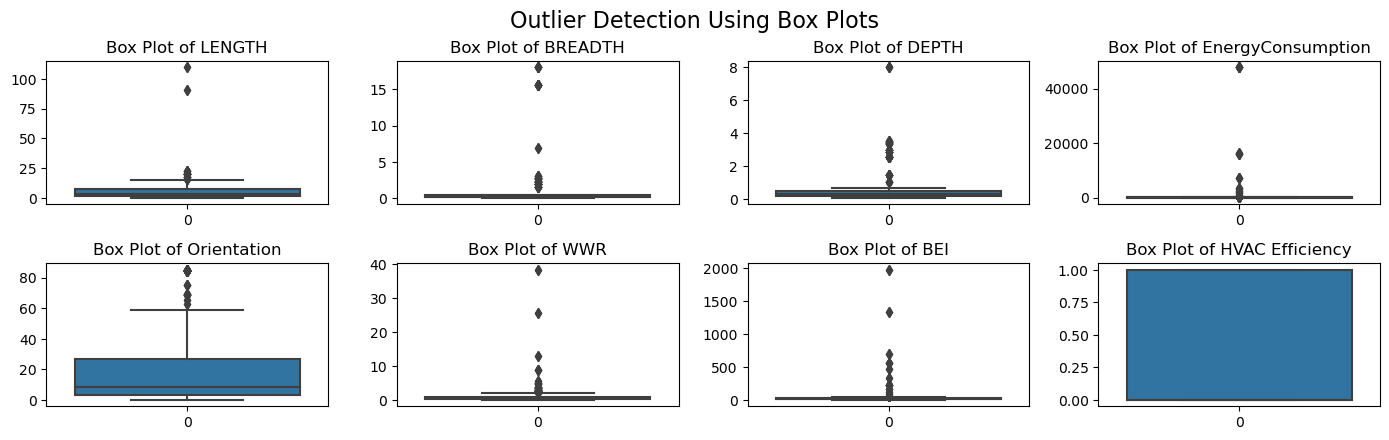

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns containing numerical data for outlier detection
numeric_columns = ['LENGTH', 'BREADTH', 'DEPTH', 'EnergyConsumption', 'Orientation', 'WWR','BEI','HVAC Efficiency']

# Calculate z-scores for outlier detection
z_scores = (data[numeric_columns] - data[numeric_columns].mean()) / data[numeric_columns].std()
z_scores

# Set a threshold for identifying outliers (e.g., z-score > 3)
outlier_threshold = 3

# Create a DataFrame to store outlier information
outliers_df = pd.DataFrame(index=data.index)

# Identify outliers using z-scores and visualize them using box plots
plt.figure(figsize=(14, 8))
for i, column in enumerate(numeric_columns, start=1):
    outliers_df[f'{column}_outlier'] = np.abs(z_scores[column]) > outlier_threshold
    
    plt.subplot(4, 4, i)
    sns.boxplot(data=data[column])
    plt.title(f'Box Plot of {column}')
    plt.tight_layout()

plt.suptitle('Outlier Detection Using Box Plots', y=1.02, fontsize=16)
plt.show()

## OUTLIER TREATMENT

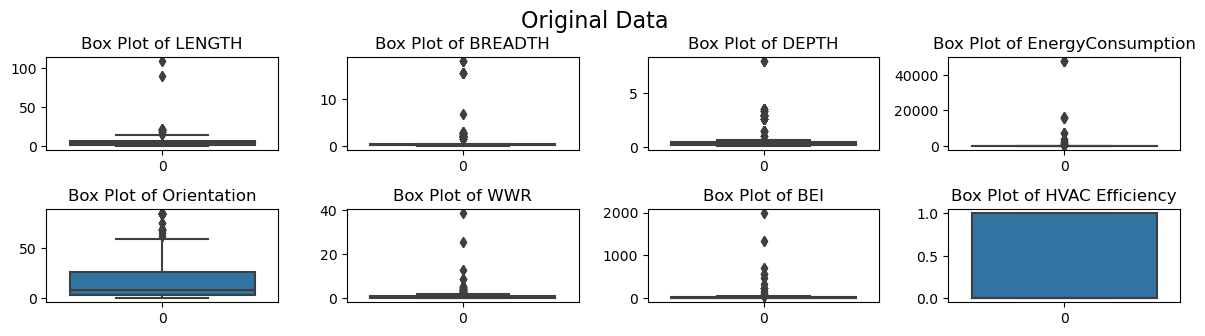

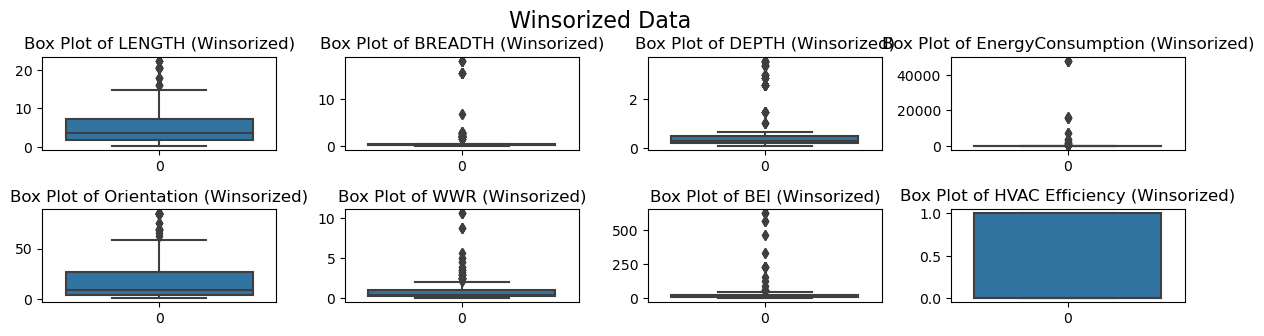

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# Assuming 'data' is your DataFrame

# Define the columns containing numerical data for outlier handling
numeric_columns = ['LENGTH', 'BREADTH', 'DEPTH', 'EnergyConsumption', 'Orientation', 'WWR','BEI','HVAC Efficiency']

# Define the lower and upper percentiles for Winsorization (e.g., 1st and 99th percentiles)
lower_percentile = 1
upper_percentile = 99

# Apply Winsorization to handle outliers
winsorized_data = data.copy()
for column in numeric_columns:
    lower_limit = np.percentile(data[column], lower_percentile)
    upper_limit = np.percentile(data[column], upper_percentile)
    winsorized_data[column] = np.clip(data[column], lower_limit, upper_limit)

# Visualize original and winsorized data using box plots
plt.figure(figsize=(12, 6))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=data[column])
    plt.title(f'Box Plot of {column}')
    plt.tight_layout()
plt.suptitle('Original Data', y=1.02, fontsize=16)
plt.show()

plt.figure(figsize=(12, 6))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=winsorized_data[column])
    plt.title(f'Box Plot of {column} (Winsorized)')
    plt.tight_layout()
plt.suptitle('Winsorized Data', y=1.02, fontsize=16)
plt.show()


## DISTRIBUTION OF DATA

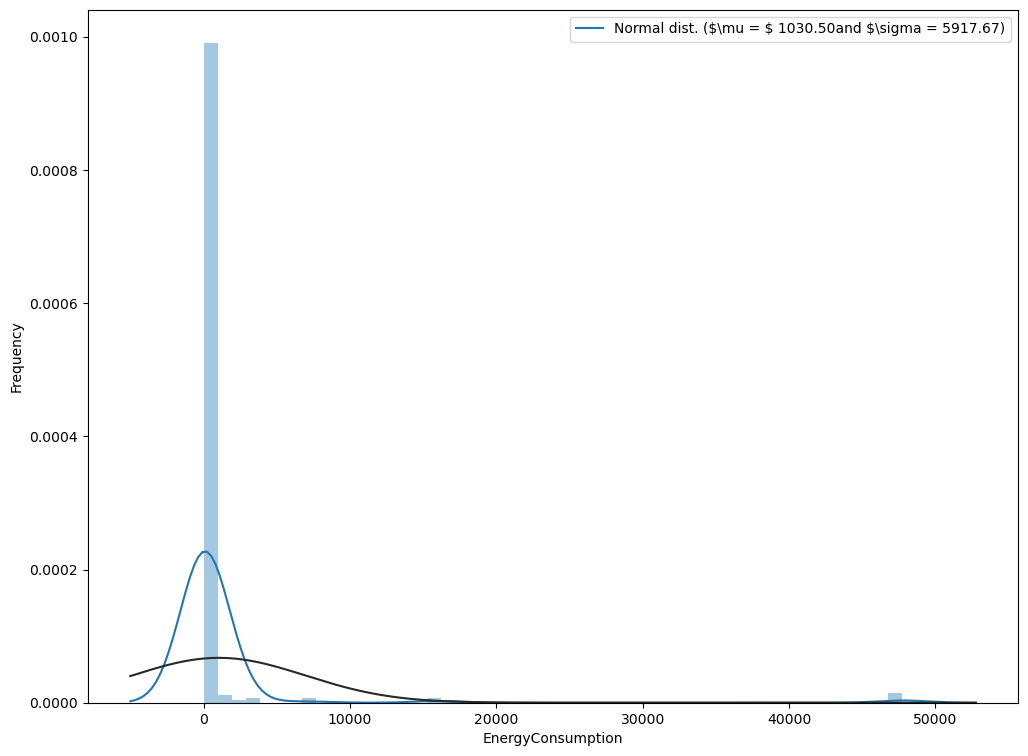

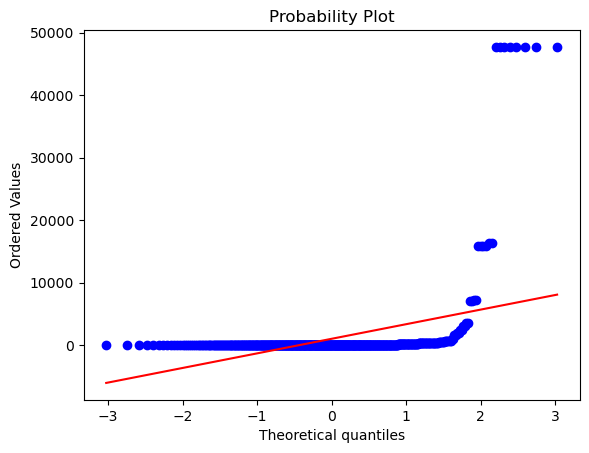

In [22]:
## Checking the distribution of the data
from scipy import stats
%matplotlib inline

plt.subplots(figsize=(12,9))
sns.distplot(data['EnergyConsumption'], fit = stats.norm)

# get the fitted parameters used by the function
(mu,sigma)= stats.norm.fit(data['EnergyConsumption'])

#plot with distribution 
plt.legend(['Normal dist. ($\mu = $ {:.2f}and $\sigma = {:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')

#PROBABILITY PLOT
fig = plt.figure()
stats.probplot(data['EnergyConsumption'],plot=plt)
plt.show()

## NORMALIZATION

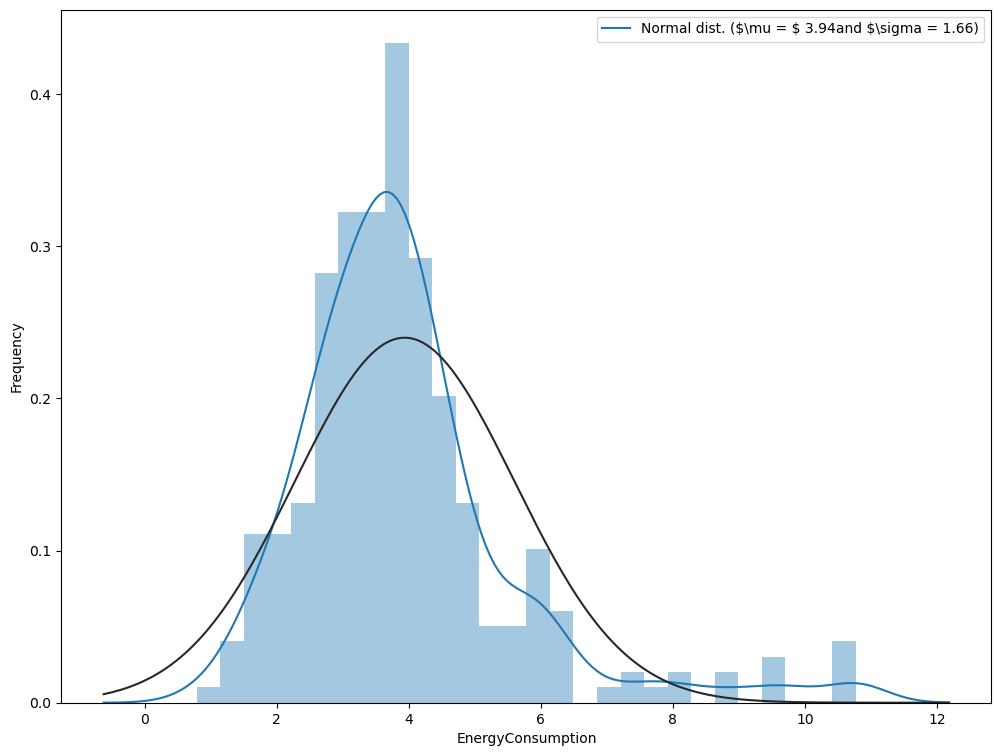

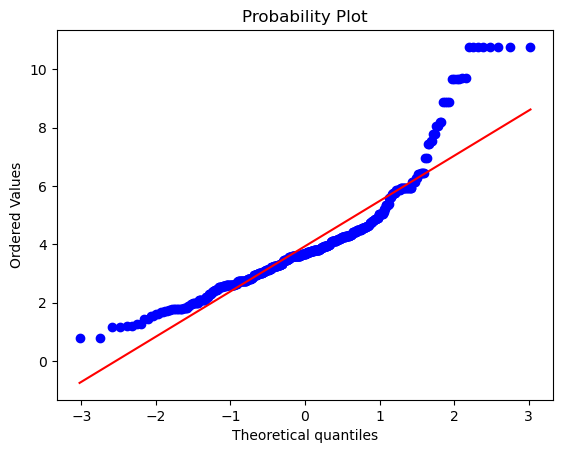

In [23]:

## We use the log which is a part of numpy library

data['EnergyConsumption'] = np.log1p(data['EnergyConsumption'])

#Check again for normal distribution 
plt.subplots(figsize =(12,9))
sns.distplot(data['EnergyConsumption'], fit = stats.norm)

#get the fitted parameters used by the function
(mu,sigma)= stats.norm.fit(data['EnergyConsumption'])

#plot with the distribution
plt.legend(['Normal dist. ($\mu = $ {:.2f}and $\sigma = {:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')

#Probability plot
fig = plt.figure()
stats.probplot(data['EnergyConsumption'],plot=plt)
plt.show()

## CORRELATION OF FEATURES

In [24]:
corr = data.corr()
corr.sort_values(['EnergyConsumption'], ascending = False , inplace = True)
corr.EnergyConsumption

EnergyConsumption    1.000000
BREADTH              0.739190
QTY                  0.661592
BEI                  0.473295
LENGTH               0.443878
WWR                  0.411849
HVAC Efficiency      0.281277
DEPTH                0.240207
Orientation          0.174527
HVAC Type           -0.281277
HVAC Size           -0.281277
Name: EnergyConsumption, dtype: float64

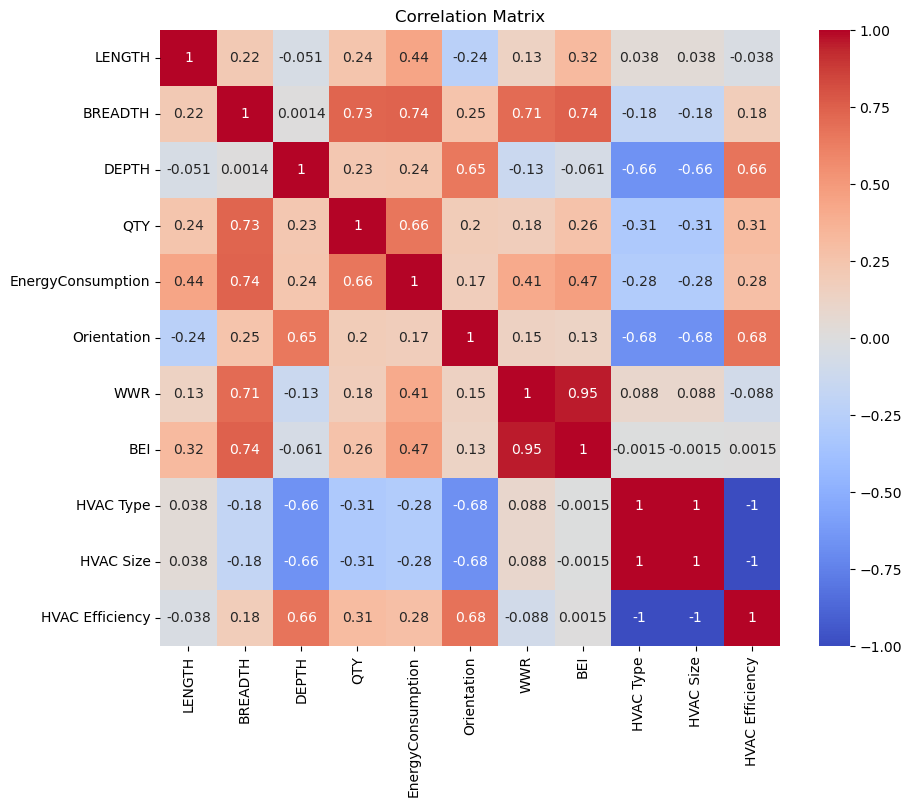

In [25]:
# Correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# MODEL BUILDING

## TRAIN-TEST SPLIT

In [69]:
## TRAIN-TEST SPLIT

X = data[['LENGTH', 'BREADTH','DEPTH', 'QTY', 'BEI','Orientation', 'WWR','HVAC Efficiency']]
y = data['EnergyConsumption']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 1. LINEAR REGRESSION- BASLINE MODEL

In [30]:
reg=LinearRegression()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)

In [31]:
## Evaluating the performance
mse=mean_squared_error(y_test,y_pred)
rmse=sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print('Mean_Squared_Error:',mse)
print('Root_Mean_Sqaured_Erro:',rmse)
print('r_sqaure_value:',r_squared)


Mean_Squared_Error: 0.6321361334542895
Root_Mean_Sqaured_Erro: 0.7950698921819952
r_sqaure_value: 0.8133929585866656


## POTENTIAL ENERGY SAVINGS OF LR

In [32]:
# Calculate the potential energy savings
energy_savings = y_test - y_pred

# Calculate the total potential energy savings
total_savings = energy_savings.sum()

# Print the total potential energy savings
print("Total Potential Energy Savings:", total_savings)

Total Potential Energy Savings: 2.59992056422145


## 2. ARTIFICIAL NEURAL NETWORK- DEEP LEARNING MODEL

In [70]:
from sklearn.preprocessing import MinMaxScaler
# Create the MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the training data (compute min and max for scaling)
scaler.fit(X_train)

# Transform the training and testing data using the scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [78]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu',input_shape=(8, ), kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, activation='relu')
])

In [79]:
model.compile(loss= 'mean_squared_error', optimizer='RMSProp', metrics=['accuracy'])
chache=model.fit(X_train_scaled,y_train, batch_size=15, epochs= 50, validation_split=0.30)

Epoch 1/50
21/21 [==============================] - 1s 19ms/step - loss: 15.0915 - accuracy: 0.0000e+00 - val_loss: 11.4355 - val_accuracy: 0.0000e+00
Epoch 2/50
21/21 [==============================] - 0s 8ms/step - loss: 8.3721 - accuracy: 0.0000e+00 - val_loss: 5.2527 - val_accuracy: 0.0000e+00
Epoch 3/50
21/21 [==============================] - 0s 8ms/step - loss: 3.8632 - accuracy: 0.0000e+00 - val_loss: 2.5142 - val_accuracy: 0.0000e+00
Epoch 4/50
21/21 [==============================] - 0s 8ms/step - loss: 2.4155 - accuracy: 0.0000e+00 - val_loss: 1.9037 - val_accuracy: 0.0000e+00
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 1.8137 - accuracy: 0.0000e+00 - val_loss: 1.6775 - val_accuracy: 0.0000e+00
Epoch 6/50
21/21 [==============================] - 0s 8ms/step - loss: 1.5467 - accuracy: 0.0000e+00 - val_loss: 1.6017 - val_accuracy: 0.0000e+00
Epoch 7/50
21/21 [==============================] - 0s 8ms/step - loss: 1.4404 - accuracy: 0.0000e+00 - val_l

In [80]:
print(model.evaluate(X_train_scaled, y_train))
print(model.evaluate(X_test_scaled,y_test))


14/14 [==============================] - 0s 3ms/step - loss: 0.8110 - accuracy: 0.0000e+00
[0.8109798431396484, 0.0]
4/4 [==============================] - 0s 7ms/step - loss: 0.9073 - accuracy: 0.0000e+00
[0.9073478579521179, 0.0]


In [81]:
result= model.predict(X_test_scaled)
result

4/4 [==============================] - 0s 4ms/step


array([[ 3.0062287],
       [ 3.1642196],
       [ 3.195059 ],
       [ 3.4477599],
       [ 3.1162255],
       [ 3.420758 ],
       [ 6.1156783],
       [ 2.5450206],
       [ 4.0471234],
       [ 3.3740628],
       [ 3.3728745],
       [ 3.233045 ],
       [ 4.2622056],
       [ 2.6212368],
       [ 4.946641 ],
       [ 4.037094 ],
       [ 4.0254407],
       [ 4.426674 ],
       [ 3.2440696],
       [ 3.3322253],
       [ 3.284992 ],
       [ 3.0211124],
       [10.32207  ],
       [ 2.9276311],
       [ 3.858134 ],
       [ 2.9576757],
       [ 3.4126825],
       [ 3.6431558],
       [ 2.5528252],
       [ 2.1059735],
       [ 3.3375313],
       [ 3.2240226],
       [ 3.8667798],
       [ 3.7704177],
       [ 3.5607214],
       [ 3.140742 ],
       [ 3.1377912],
       [ 3.449107 ],
       [ 2.952238 ],
       [ 2.630297 ],
       [ 2.730603 ],
       [ 2.9039104],
       [ 3.2679617],
       [ 4.4036417],
       [ 9.089164 ],
       [ 8.226335 ],
       [ 2.6398654],
       [ 3.18

In [93]:
# Performance of the Model
mse_ann = mean_squared_error(y_test, result)
rmse_ann=sqrt(mse_ann)
r_squared_ann = r2_score(y_test,result)

print('Mean Squared Error (MSE):', mse_ann)
print('Root_Mean_Sqaured_Erro:',rmse_ann)
print('r_sqaure_value:',r_squared_ann)

Mean Squared Error (MSE): 0.5857362964842007
Root_Mean_Sqaured_Erro: 0.7653341077491586
r_sqaure_value: 0.8270902238446014


## PLOTTING MODEL LOSS

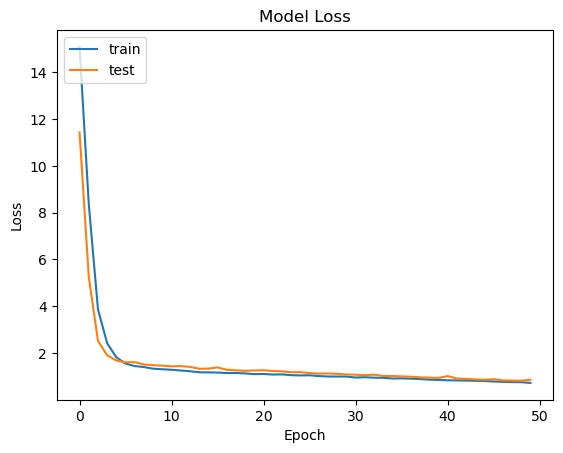

In [82]:
plt.plot(chache.history['loss'])
plt.plot(chache.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

## POTENTIAL ENERGY SAVINGS OF ANN

In [83]:
import numpy as np

# Assuming y_test and result are pandas Series or arrays
y_test = np.array(y_test)
result = np.array(result)

# Calculate the potential energy savings
energy_savings_ann = y_test - result

# Calculate the total potential energy savings
total_savings_ann = energy_savings_ann.sum()

# Print the total potential energy savings
print("Total Potential Energy Savings:", total_savings_ann)


Total Potential Energy Savings: 4179.060842194049


# ACTUAL v/s PREDICTED PLOT

14/14 [==============================] - 0s 3ms/step


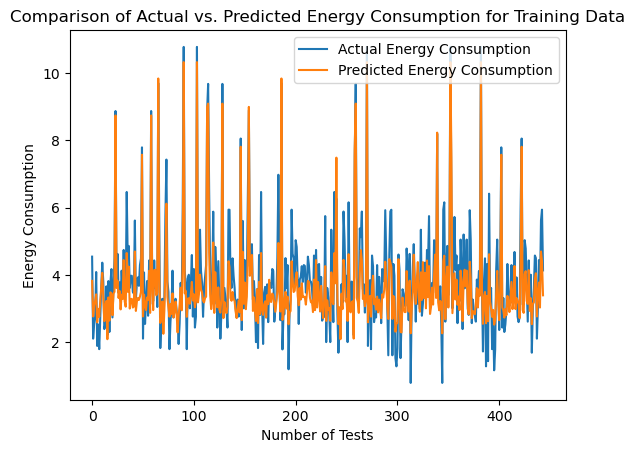

In [86]:
result2 = model.predict(X_train_scaled)

# Generate an array of indices for the testing set
indices = range(len(y_train))

# Plot the predicted values and the actual values
plt.plot(indices, y_train, label='Actual Energy Consumption')
plt.plot(indices, result2, label='Predicted Energy Consumption')
plt.xlabel('Number of Tests')
plt.ylabel('Energy Consumption')
plt.title('Comparison of Actual vs. Predicted Energy Consumption for Training Data')
plt.legend()
plt.show()

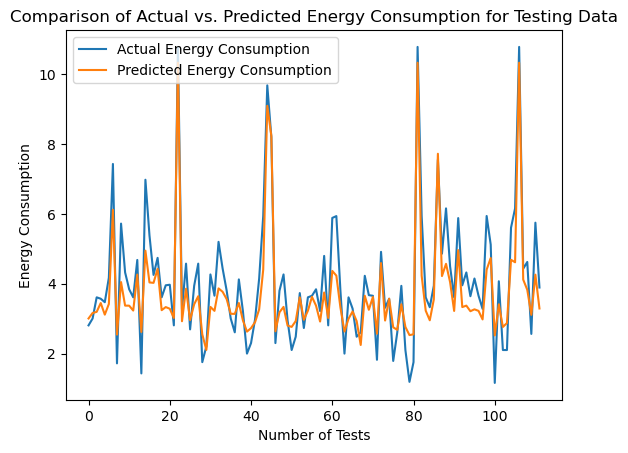

In [87]:
## COMAPRISON ACTUAL V/S PREDICTION


# Generate an array of indices for the testing set
indices = range(len(y_test))

# Plot the predicted values and the actual values
plt.plot(indices, y_test, label='Actual Energy Consumption')
plt.plot(indices, result, label='Predicted Energy Consumption')
plt.xlabel('Number of Tests')
plt.ylabel('Energy Consumption')
plt.title('Comparison of Actual vs. Predicted Energy Consumption for Testing Data')
plt.legend()
plt.show()


# CONCLUSION

## 1.PERFROMANCE OF MODEL
- On comapring the performance of the model we can observe that the deep learning model ANN is performing a little better as compared to our baseline model i.e. Linear Regression model in terms of accuracy.

## 2. POTENTIAL ENERGY SAVINGS
- Energy savings, in the context of building energy efficiency referS to the reduction in energy consumption achieved through our models.
- To calculate potential energy savings:
  - Potential Energy Savings = Actual Energy Consumption - Predicted Energy Consumption

- Positive Potential Energy Savings , indicates that the model predicts that the energy consumption will be lower than the actual initial consumption, suggesting potential savings.

- Our goal was to have a positive Potential Energy Savings value, which implied that the proposed changes are expected to reduce energy consumption compared to the initial state.

- In our case both the models were working well in order to reduce the energy consumption. But comparing the ANN and LR model there is evident difference in the potential energy savings. ANN model is working well and showing more energy savings as comapred to LR model